In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/DDU+CE"

/content/drive/MyDrive/DDU+CE


In [3]:
import torch
import numpy as np


CE_dir = 'batch_CEs_50/'
v = 'v'                 # 'v' if validation set examples (for loading arrays)
batch_size = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').to(device)
labels_exp = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').unsqueeze(1).expand(batch_size, 10)
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())

print('device: ', device)

device:  cpu


## Analysis

In [4]:
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())
originals = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_X.pt')
orig_exp = originals.expand(100,10,28,28)

iter = {}
im = {}
L0 = {}
L1 = {}
mask = {}

In [5]:
coeff = 0

for lam in [-1,0]: # exclude for mask_all copmutation below
  for step_size in [-3,-4,-5]:
  
    if step_size == -3:
      max_iter = 5000
    elif step_size == -5:
      max_iter = 50000
    else:
      max_iter = 10000

    method = f'l{lam}s{step_size}'
    load_method = f'REVISE_l{lam}s{step_size}'

    iter[method] = torch.load(CE_dir + f'{load_method}_iter_{v}batch_c{int(coeff)}.pt')
    im[method] = torch.load(CE_dir + f'{load_method}_arr_{v}batch_c{int(coeff)}.pt').reshape(100,10,28,28)
    L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
    L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
    mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

## show images

<Figure size 432x288 with 0 Axes>

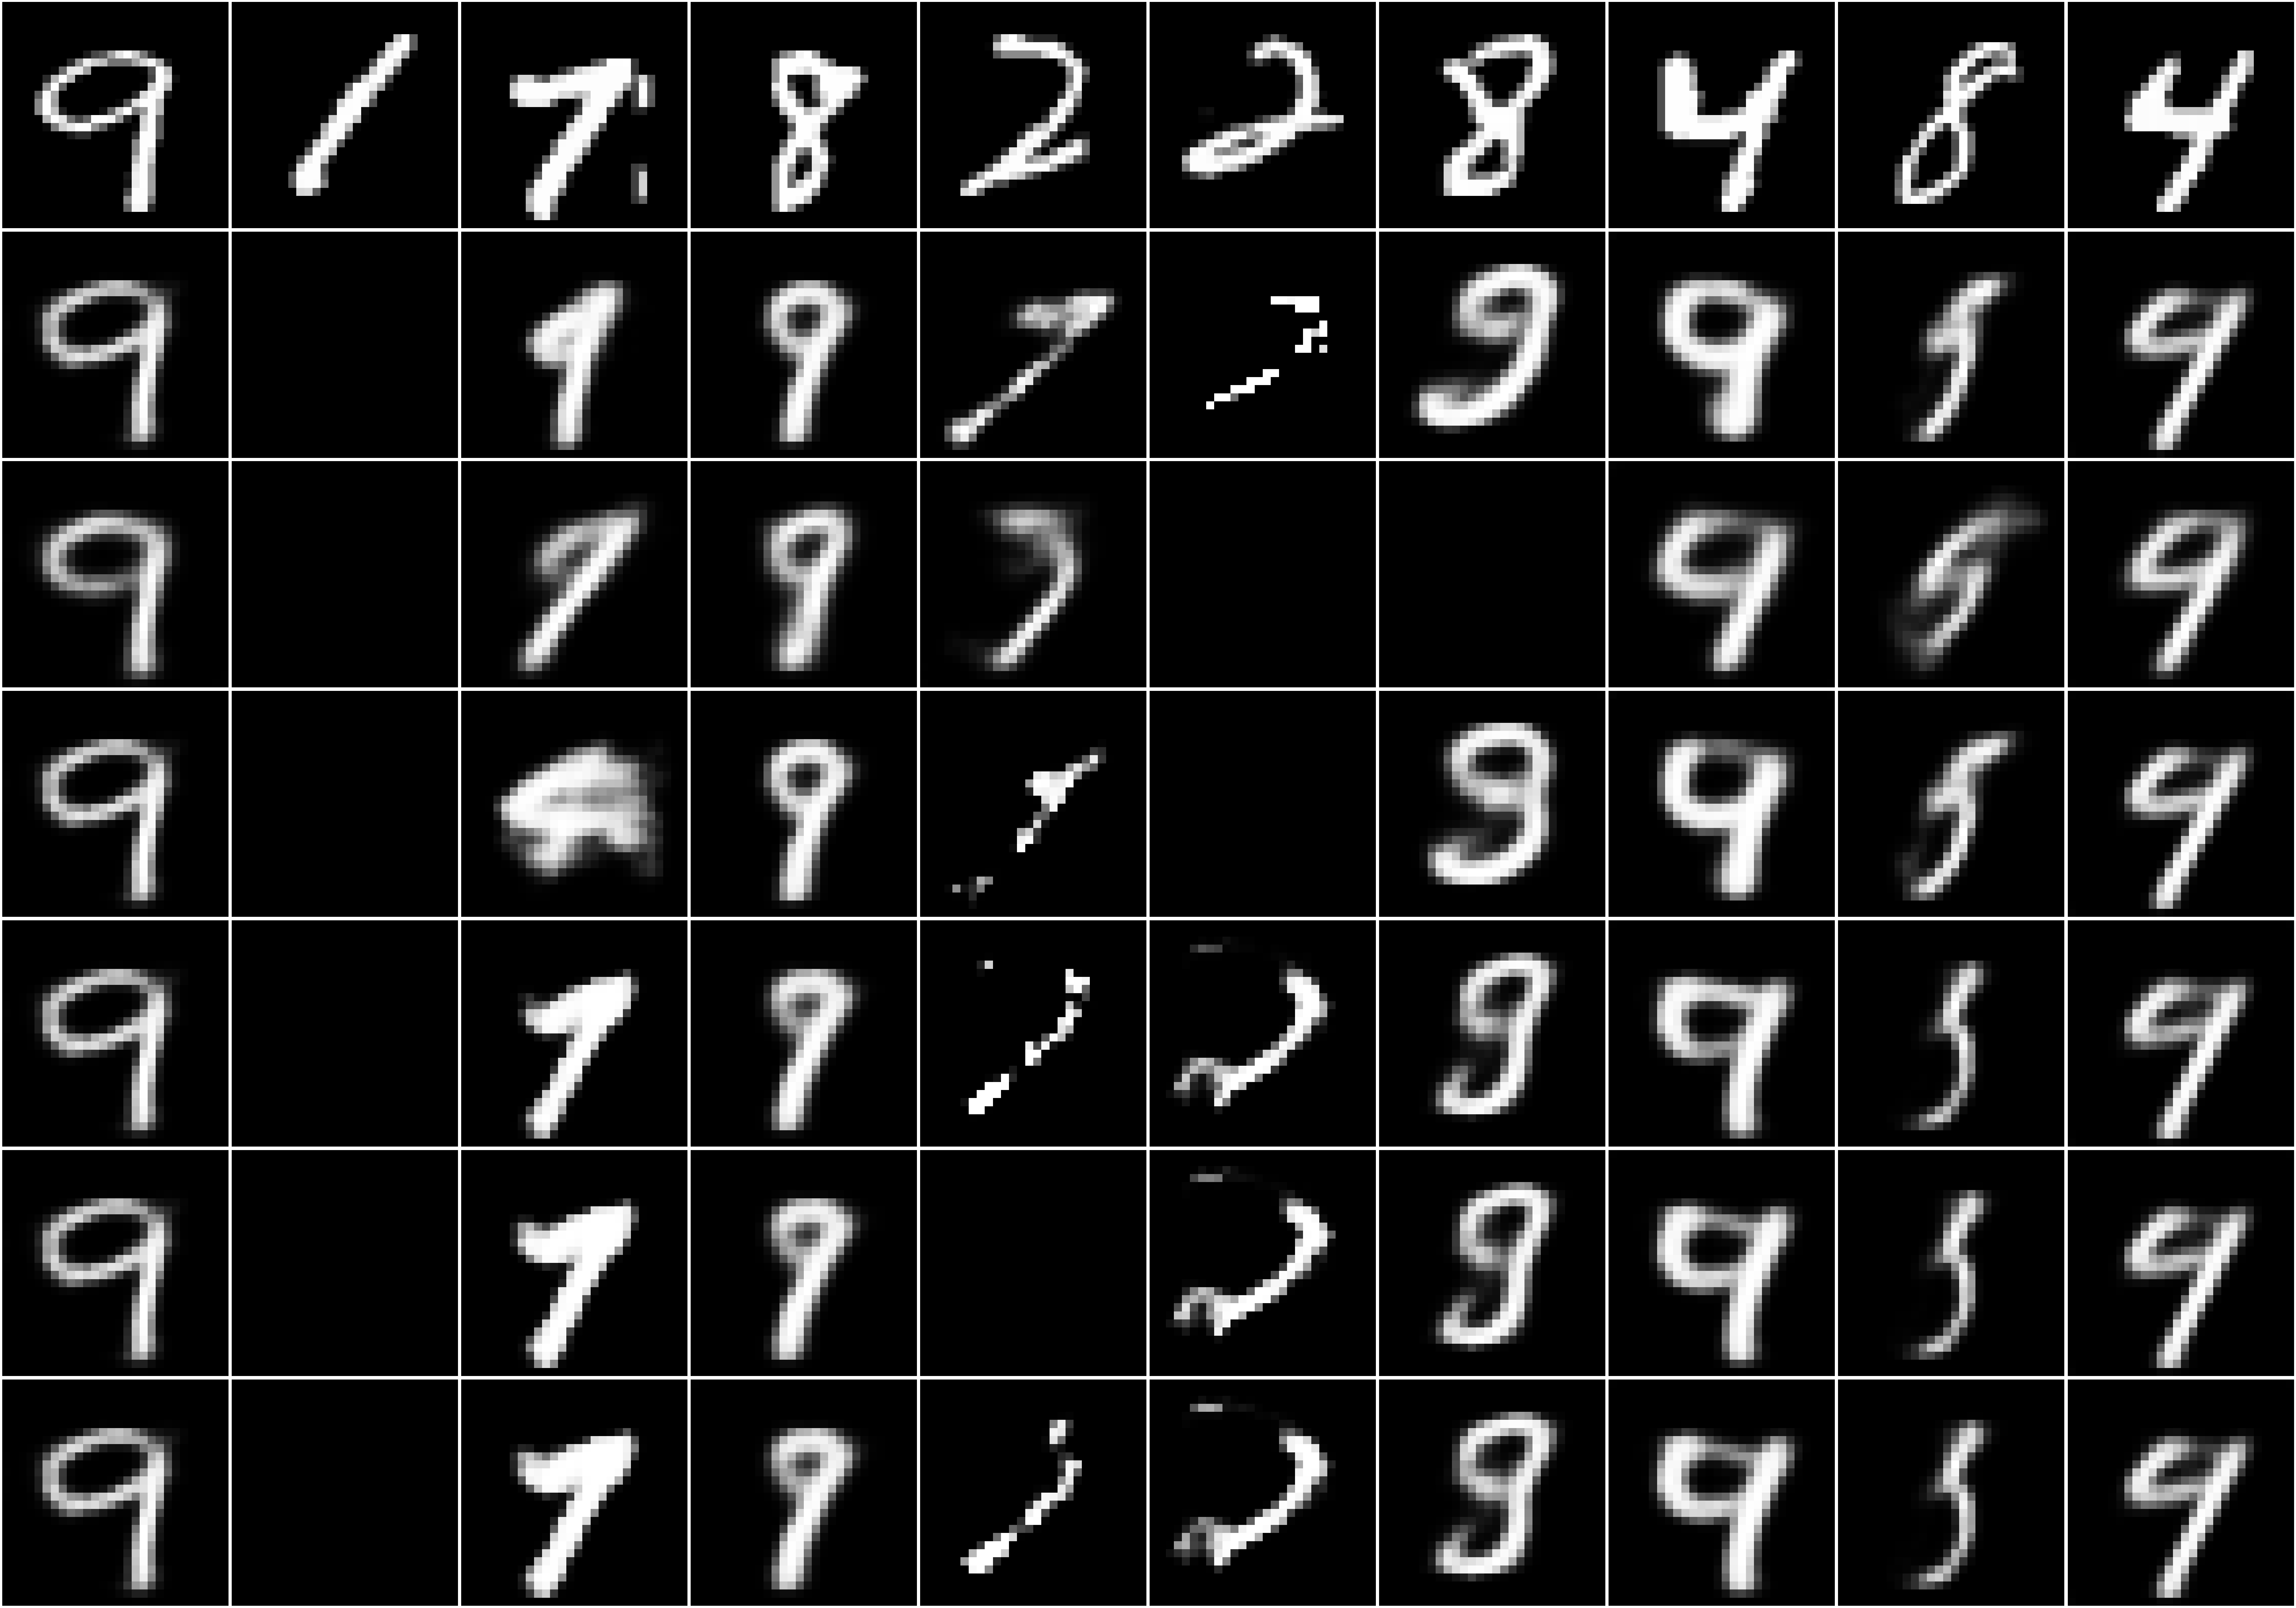

In [6]:
import matplotlib.pyplot as plt
plt.gray()

n_rows = len(im) + 1

def r2(x):
    return np.round(x.numpy(), 2)


target = 9

fig = plt.figure(figsize=(100, n_rows*10))
num=10
start = 0

for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (0, i))
    plt.imshow(originals[start+i].view(28,28))
    plt.axis('off')

k = 1
for method in im.keys():
  for i in range(num):
      ax = plt.subplot2grid((n_rows,num), (k, i))
      plt.imshow(im[method][start+i,target])
      plt.axis('off')
  k += 1
plt.tight_layout()

### results table

In [7]:
def r2mean(x):
    return np.round(x.mean().item(), 2)
def r2std(x):
    return np.round(x.std().item(), 2)

mask_all = mask['l0s-4'] #& mask['c5'] # compare on same examples
for alg in im.keys():
  mask_all = mask_all & mask[alg]

for alg in im.keys():
  print(alg, '  L0: ', r2mean(L0[alg][mask_all].float()), '  L1: ', r2mean(L1[alg][mask_all]), '  good:', mask[alg].sum().item())
  
# STDs
print('STDs:')
for alg in im.keys():
  print(alg, '  L0: ', r2std(L0[alg][mask_all].float()),   '  L1: ', r2std(L1[alg][mask_all]))

l-1s-3   L0:  754.34   L1:  88.79   good: 755
l-1s-4   L0:  758.12   L1:  91.43   good: 792
l-1s-5   L0:  764.93   L1:  84.92   good: 794
l0s-3   L0:  767.75   L1:  58.66   good: 693
l0s-4   L0:  771.78   L1:  54.72   good: 663
l0s-5   L0:  771.89   L1:  54.11   good: 700
STDs:
l-1s-3   L0:  109.07   L1:  28.42
l-1s-4   L0:  96.57   L1:  28.29
l-1s-5   L0:  86.06   L1:  29.77
l0s-3   L0:  68.3   L1:  14.56
l0s-4   L0:  59.41   L1:  11.75
l0s-5   L0:  60.84   L1:  11.95


## how many iterations actually needed? (lambda=1)

In [8]:
lam = 0
for step_size in [-3,-4,-5]:
  print('step_size', step_size)
  load_method = f'REVISE_l{lam}s{step_size}'
  iter = torch.load(CE_dir + f'{load_method}_iter_{v}batch_c{int(coeff)}.pt')
  max_iter = iter.max().item()
  for fac in [.2, .4, .6, .8, 1.]:
    iters = max_iter * fac
    print(iters, ((targets != labels_exp) & (iter < iters)).sum().item())

step_size -3
1000.0 633
2000.0 663
3000.0 681
4000.0 688
5000.0 693
step_size -4
2000.0 589
4000.0 628
6000.0 648
8000.0 654
10000.0 663
step_size -5
10000.0 619
20000.0 657
30000.0 677
40000.0 692
50000.0 700
